TODO:
1. Найти распределение вероятностей для каждого состояния
2. Построить график количества людей в системе от времени
3. Построить график среднего времени нахождения клиента в системе от времени

In [23]:
import threading
import random
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as napas

In [24]:
N_CLIENTS = 50

LAMBDA = 1
MU1 = 2
MU2 = 2

LOGGING = False

clients_list = []

event = threading.Event()
event.set()

In [25]:

timings = []

def get_state(chair1, chair2) -> str:
    if (not chair1.is_busy and not chair2.is_busy):
        return '00'
    if (not chair1.is_busy and chair2.is_busy):
        return '01'
    if (chair1.is_busy and not chair2.is_busy):
        return '10'
    if(chair1.is_blocked and chair2.is_busy):
        return 'b1'
    if (chair1.is_busy and chair2.is_busy):
        return '11'

In [26]:
class Client:
    def __init__(self, id):
        self.id = id
        self.start_time = None
        self.finish_time = None


In [27]:
class Chair1:
    def __init__(self):
        self.is_busy = False
        self.is_blocked = False
    
    def serving(self, client: Client, mu1):
        random.seed()
        ksi = random.expovariate(mu1)
        self.is_busy = True
        if LOGGING:
            print(f'client {client.id} is starting serving on the 1 chair')
        time.sleep(ksi)
        if LOGGING:
            print(f'client {client.id} finished serving on the 1 chair')
        return ksi
    

In [28]:
class Chair2:
    def __init__(self):
        self.is_busy = False
    
    def serving(self, client: Client, mu2):
        random.seed()
        ksi = random.expovariate(mu2)
        self.is_busy = True
        if LOGGING:
            print(f'client {client.id} is starting serving on the 2 chair')
        time.sleep(ksi)
        if LOGGING:
            print(f'client {client.id} finished serving on the 2 chair')
        return ksi

In [29]:
def append_timing(timings: list, state: str, time):
    if len(timings) != 0 and timings[-1][0] == state:
        timings.pop()
    timings.append((state, time))

In [30]:
def serving(client: Client, chair1: Chair1, chair2: Chair2, start_time, mu1, mu2):
    # if LOGGING:
    #     print(f'CLIENT {client.id} STARTED SERVING')
    client.start_time = time.time() - start_time

    t = time.time() - start_time
    append_timing(timings, get_state(chair1, chair2), t)
    t_1 = t+chair1.serving(client, mu1)
    append_timing(timings, get_state(chair1, chair2), t_1)

    if not event.is_set():
        chair1.is_blocked = True
        # if LOGGING:
        #     print(f'client {client.id} is waiting for chair 2')

    t = time.time() - start_time
    event.wait()
    event.clear()

    t = time.time() - start_time
    append_timing(timings, get_state(chair1, chair2), t)
    chair1.is_busy = False
    chair1.is_blocked = False
    t_2 = t+chair2.serving(client, mu2)
    append_timing(timings, get_state(chair1, chair2), t_2)
    
    chair2.is_busy = False
    
    event.set()
    client.finish_time = t_2
    clients_list.append(client)


In [31]:
def get_theor_stats(lm, m1, m2):
    pi_00 = ((m1 + m2) * m2**2 * m1)/((m1+m2)*m1*m2**2 + lm*(m1+m2)*m2**2 + lm**2*m2**2 + lm*(m1+m2)*m1*m2+lm**2*m2*m1+m1**2*lm**2)
    pi_10 = pi_00 * (lm/m1 + lm**2/((m1+m2)*m1))
    pi_01 = pi_00 * lm/m2
    pi_11 = pi_00 * lm**2/((m1 + m2)*m2)
    pi_b1 = pi_00 * m1 * lm**2/((m1 + m2) * m2**2)
    E_clients = pi_01 + pi_10 + 2*(pi_11 + pi_b1)
    E_time = (pi_01 + pi_10 + 2*(pi_11 + pi_b1))/(lm*(pi_00 + pi_01))
    return (pi_00, pi_10, pi_01, pi_11, pi_b1), E_clients, E_time

In [32]:
def simulate(n_clients, _lambda, mu1, mu2) -> dict:
    import time
    results = {}
    
    chair1 = Chair1()
    chair2 = Chair2()

    serving_start = time.time()

    start_time = time.time()

    for i in tqdm(range(n_clients)):
        random.seed()
        ksi = random.expovariate(_lambda)
        time.sleep(ksi)
        if not chair1.is_busy:
            x = threading.Thread(target=serving, args=(Client(i + 1), chair1, chair2, start_time, mu1, mu2))
            x.start()   
        # else:
        #     if LOGGING:
        #         print(f'CLIENT {i + 1} WAS REJECTED')
        
    x.join()
    # serving_end = time.time()


    total_time = clients_list[-1].finish_time

    # if LOGGING:
    #     print(f'Serving finished, total time: {total_time}')
    #     for client in clients_list: 
    #         print(f'id: {client.id}, time in system: {client.finish_time - client.start_time}')
    probs = {'00': .0,
         '10': .0,
         '01': .0,
         '11': .0,
         'b1': .0}

    prev_time = 0
    for item in timings:
        state = item[0]
        time = item[1]
        probs[state] += (time - prev_time) / total_time
        prev_time = time  
        
    # for k,v in probs.items():
    #     print(f'pi_{k} ~ {v:.3f}')
    results['probs'] = probs
        
    times = []
    states = []
    for state, time in timings:
        if state == 'b1':
            _state = '11'
        else:
            _state = state
        states.append(int(_state[0]) + int(_state[1]))
        
    for client in clients_list:
        times.append(client.finish_time - client.start_time)
        
    x = []
    y = []
    for i, item in enumerate(timings):
        state = item[0]
        time = item[1]
        if state == 'b1':
            _state = '11'
        else:
            _state = state
        y.append((int(_state[0]) + int(state[1]) + sum(states[:i])) / (len(y) + 1))
        x.append(time)
        
    results['average_clients_plot'] = (x, y)
        
    x = []
    y = []
    for i, client in enumerate(clients_list):
        x.append(client.finish_time)
        y.append((client.finish_time - client.start_time + sum(times[:i])) / (len(y) + 1) )
        
    results['average_time_plot'] = (x, y)
    results['times'] = times
    results['states'] = states
    
    return results

In [112]:
def plot_clients_avg(res, gt, lm, mu1, mu2):
    x = res['average_clients_plot'][0]
    y = res['average_clients_plot'][1]
    plt.figure(figsize=(20, 10))
    plt.title(f'average amount of clients\nlambda: {lm}\nmu1: {mu1}\nmu2: {mu2}')
    plt.plot(x, y)
    plt.plot(x, napas.full(len(x), napas.mean(res['states'])), label='Выборочное среднее', linestyle='dashed')
    plt.plot(x, napas.full(len(x), napas.mean(gt[1])), label='Мат. ожидание', linestyle='dashed')
    plt.xlabel('time in secs')
    plt.ylabel('average amount of people in system')
    plt.legend(loc='lower right', fontsize=13)

In [113]:
def plot_time_avg(res, gt, lm, mu1, mu2):
    x = res['average_time_plot'][0]
    y = res['average_time_plot'][1]
    plt.figure(figsize=(20, 10))
    plt.title(f'average time\nlambda: {lm}\nmu1: {mu1}\nmu2: {mu2}')
    plt.plot(x, y)
    plt.plot(x, napas.full(len(x), napas.mean(res['times'])), label='Выборочное среднее', linestyle='dashed')
    plt.plot(x, napas.full(len(x), napas.mean(gt[2])), label='Мат. ожидание', linestyle='dashed')
    plt.xlabel('time in secs')
    plt.ylabel('average time of serving a customer')
    plt.legend(loc='lower right', fontsize=13)

### Эксперимент 1 (lm: 1, mu1: 2.5, mu2: 2)

In [115]:
lm = 1
mu1 = 2.5
mu2 = 2

In [35]:
clients_list = []
timings = []
stats1 = get_theor_stats(1, 2.5, 2)
res1 = simulate(1000, 1, 2.5, 2)

100%|██████████| 1000/1000 [16:41<00:00,  1.00s/it]


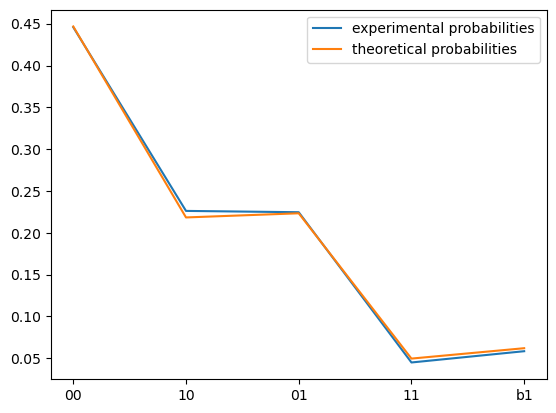

In [116]:
plt.plot(res1['probs'].keys(), res1['probs'].values(), label='experimental probabilities')
plt.plot(res1['probs'].keys(), stats1[0], label='theoretical probabilities')
plt.legend()

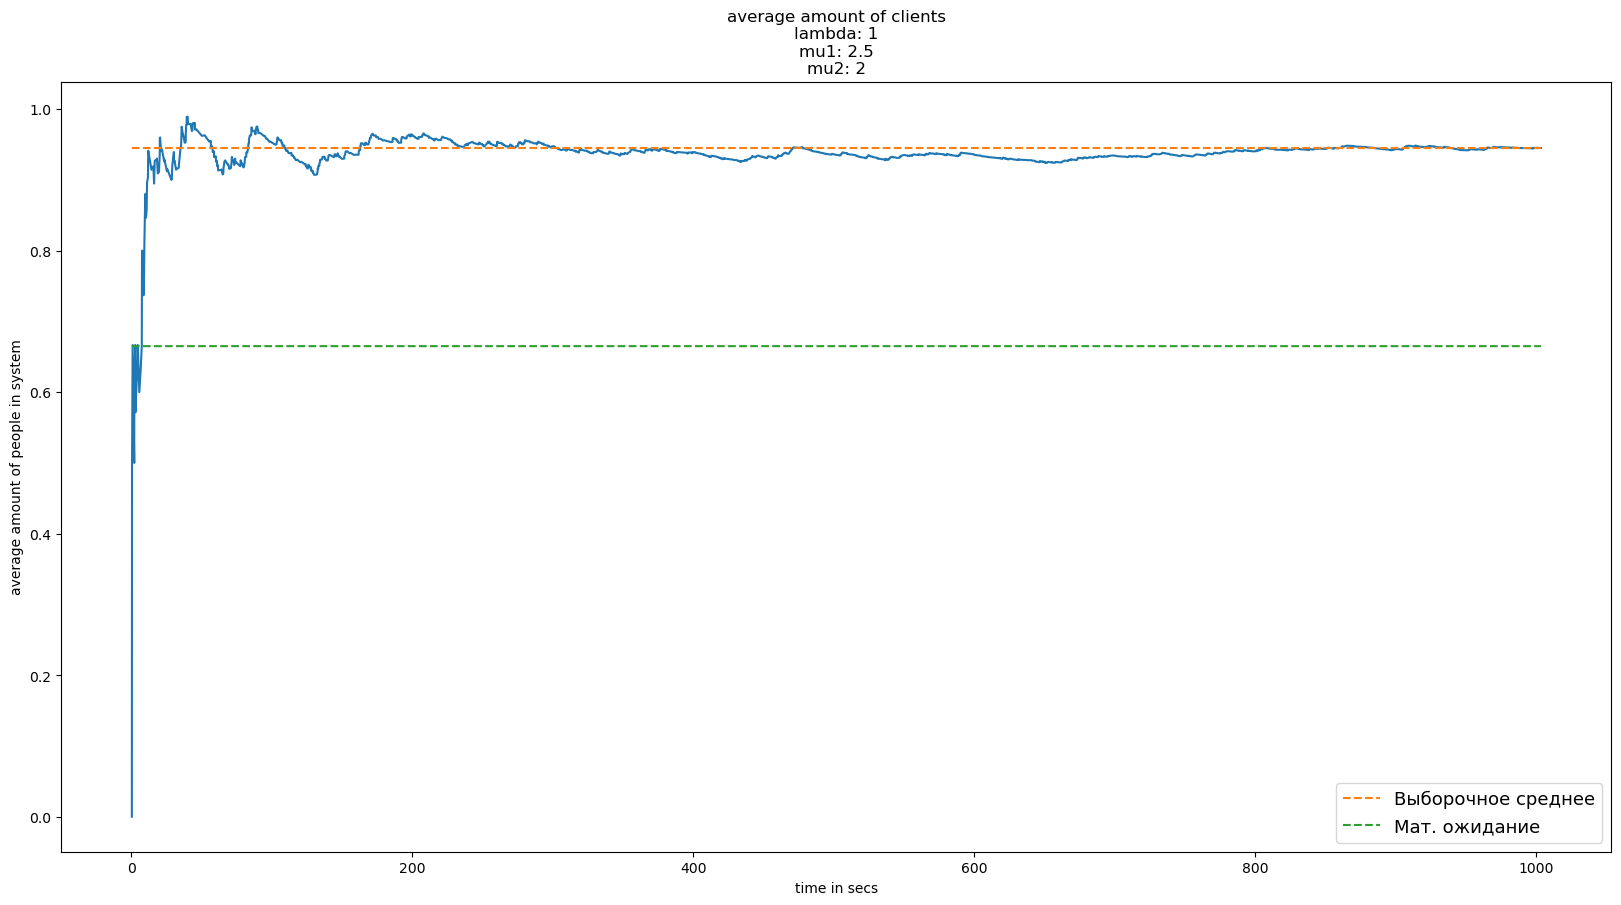

In [117]:
plot_clients_avg(res1, stats1, lm, mu1, mu2)

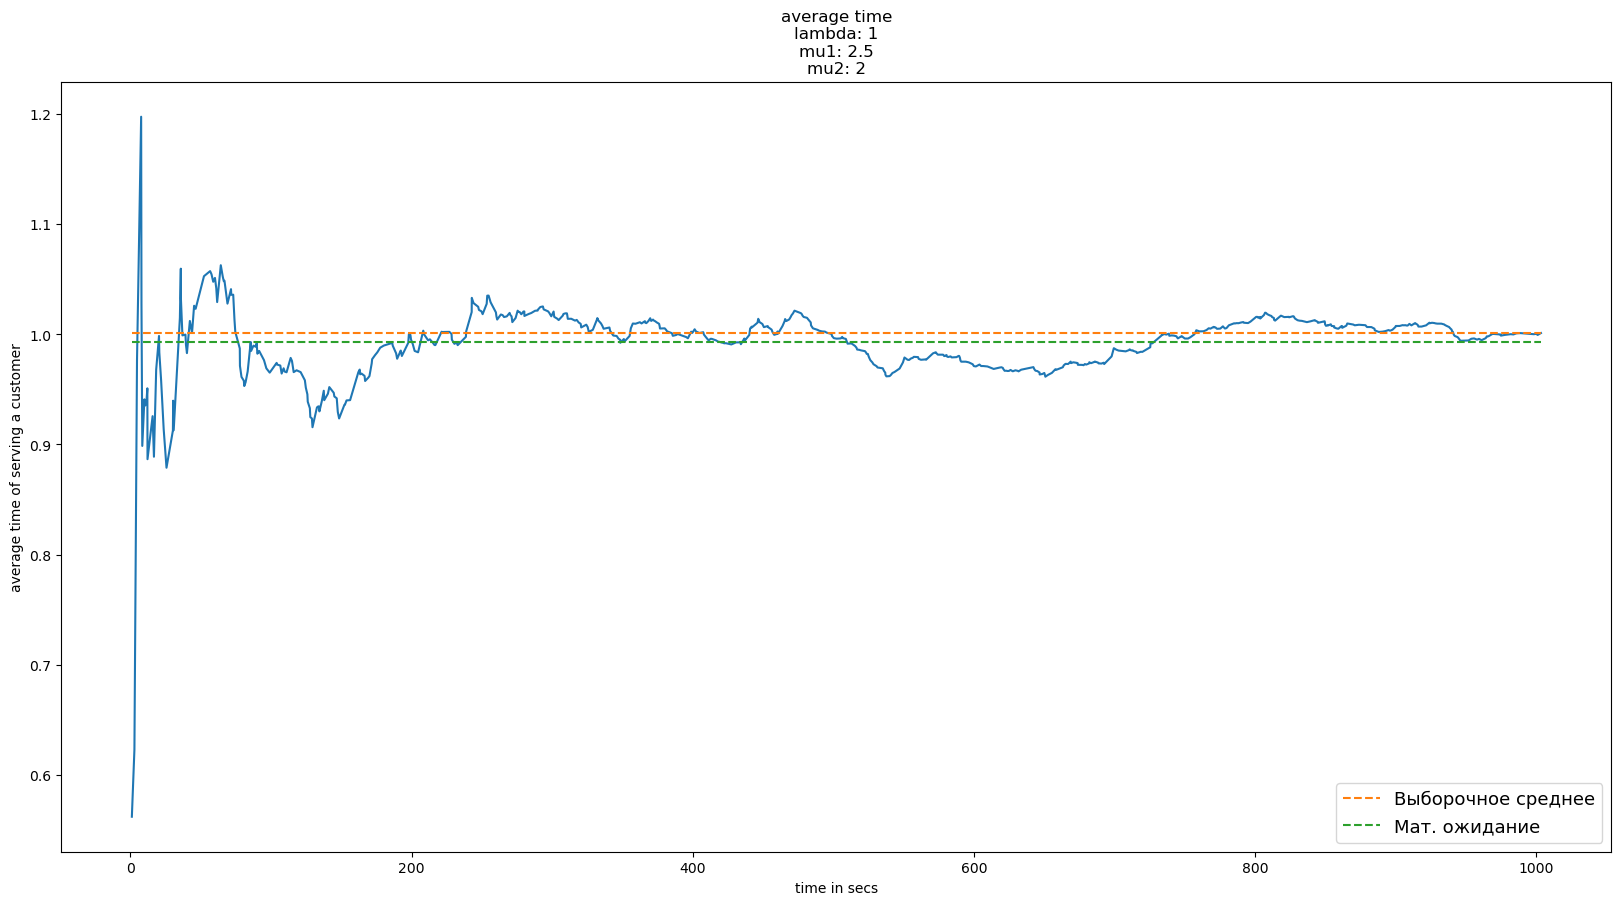

In [118]:
plot_time_avg(res1, stats1, lm, mu1, mu2)

### Эксперимент 2 (lm: 2, mu1: 1, mu2: 1.5)

In [119]:
lm = 2
mu1 = 1
mu2 = 1.5

In [39]:
clients_list = []
timings = []
stats2 = get_theor_stats(2, 1, 1.5)
res2 = simulate(1000, 2, 1, 1.5)

100%|██████████| 1000/1000 [08:25<00:00,  1.98it/s]


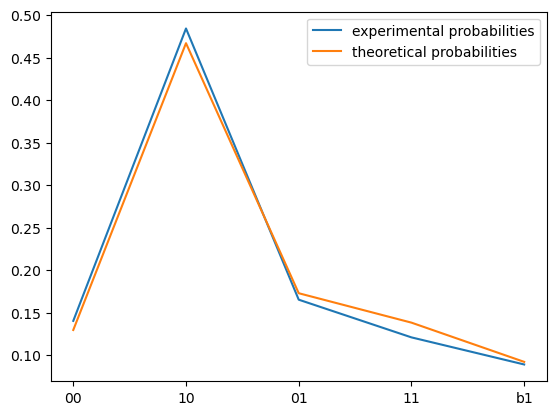

In [120]:
plt.plot(res2['probs'].keys(), res2['probs'].values(), label='experimental probabilities')
plt.plot(res2['probs'].keys(), stats2[0], label='theoretical probabilities')
plt.legend()

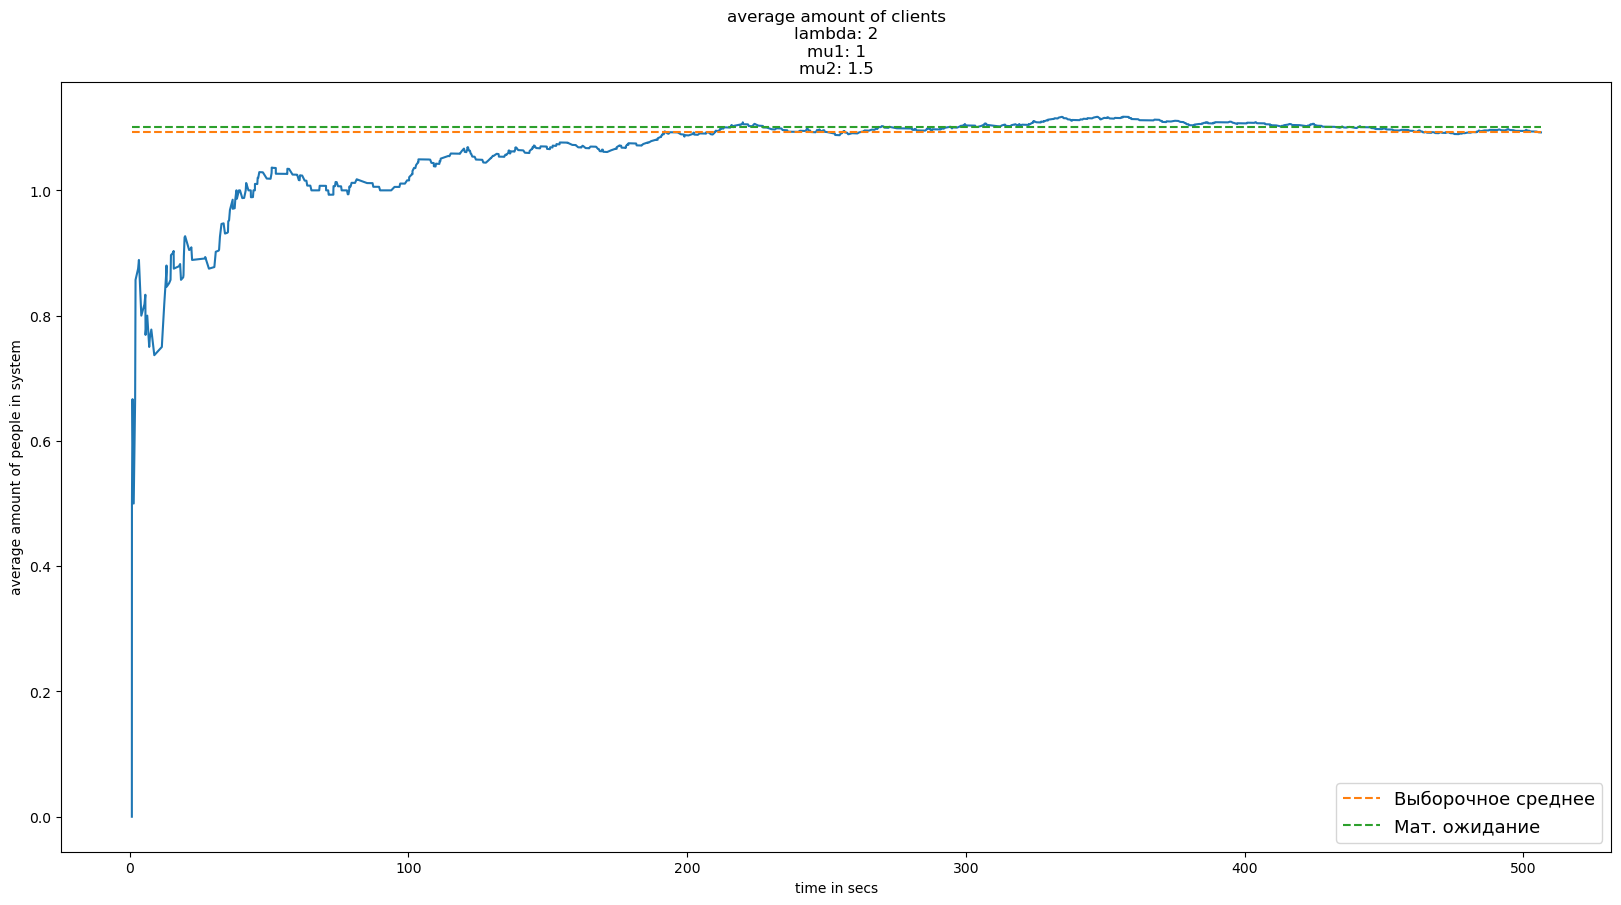

In [121]:
plot_clients_avg(res2, stats2, lm, mu1, mu2)

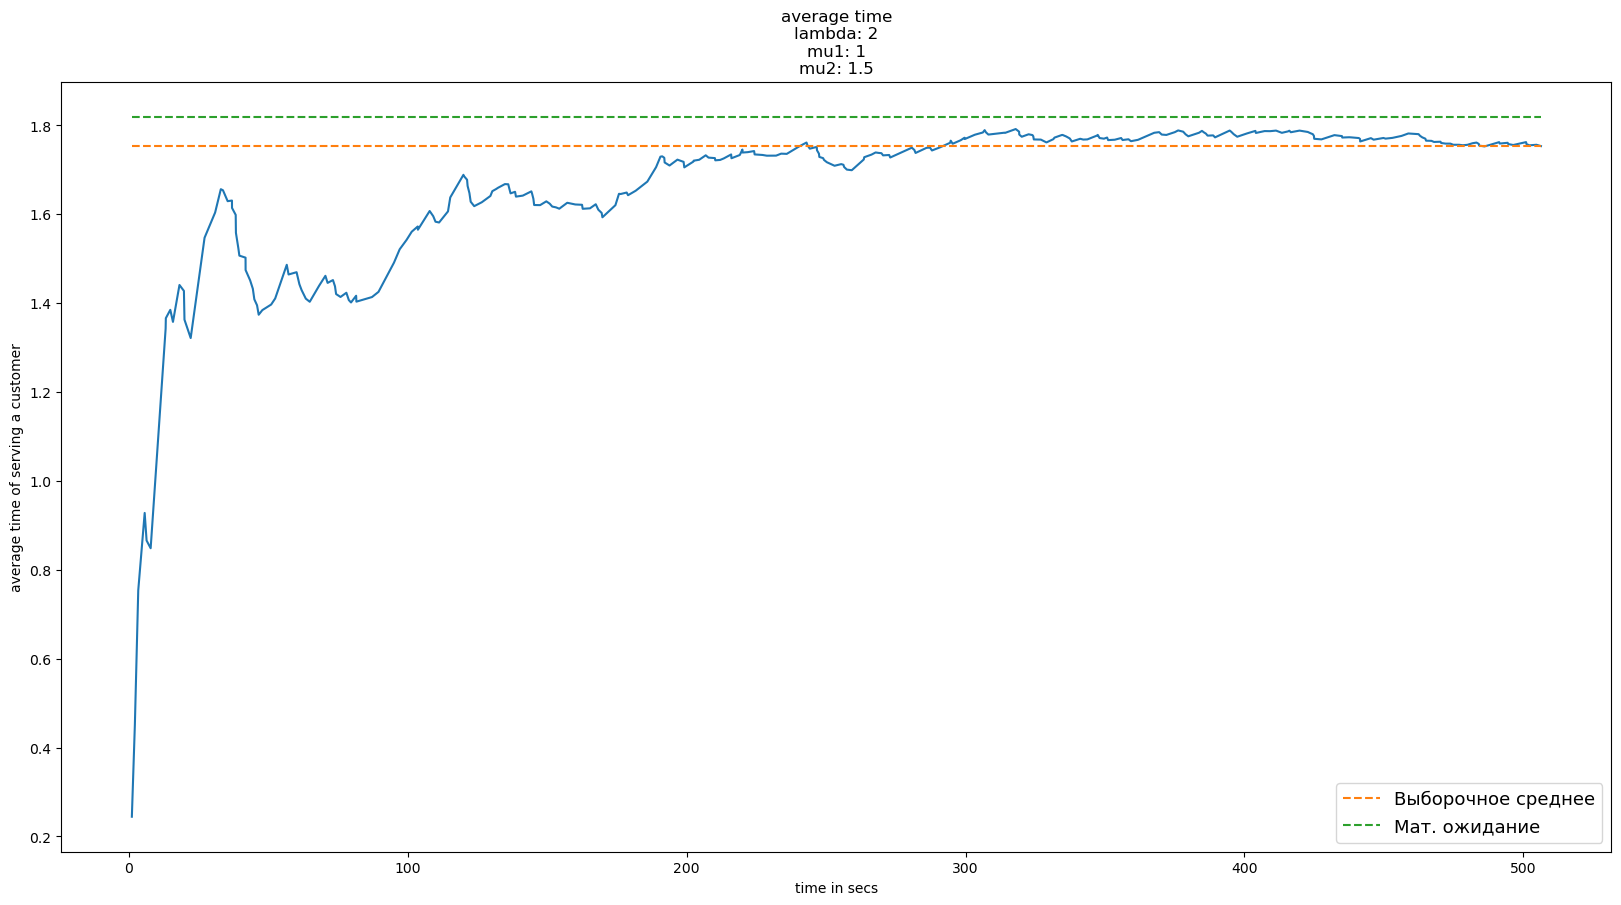

In [122]:
plot_time_avg(res2, stats2, lm, mu1, mu2)

### Эксперимент 3 (lm: 2.5, mu1: 2, mu2: 1)

In [123]:
lm = 2.5
mu1 = 2
mu2 = 1

In [56]:
clients_list = []
timings = []
stats3 = get_theor_stats(2.5, 2, 1)
res3 = simulate(1000, 2.5, 2, 1)

100%|██████████| 1000/1000 [06:39<00:00,  2.50it/s]


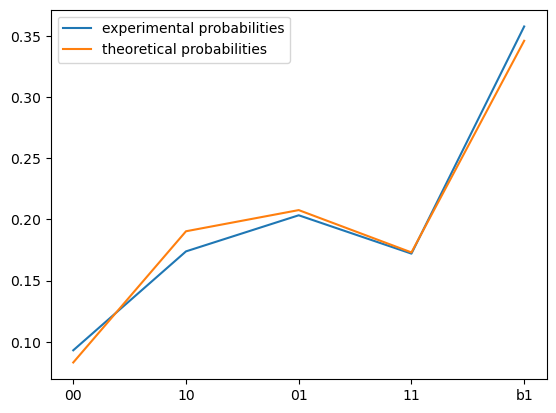

In [124]:
plt.plot(res3['probs'].keys(), res3['probs'].values(), label='experimental probabilities')
plt.plot(res3['probs'].keys(), stats3[0], label='theoretical probabilities')
plt.legend()

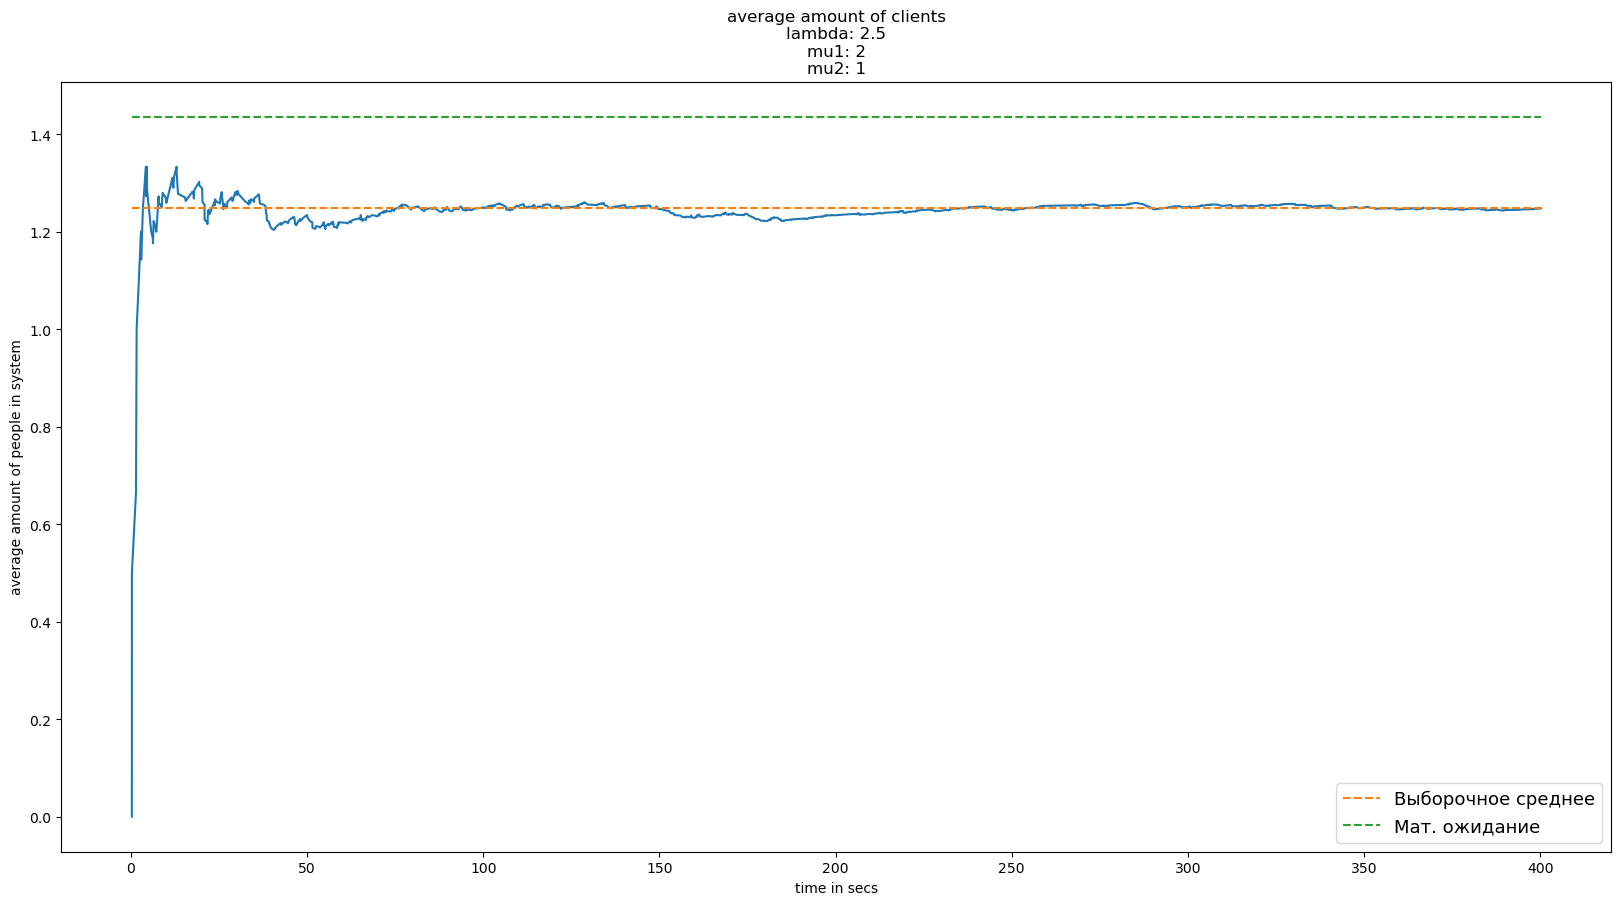

In [125]:
plot_clients_avg(res3, stats3, lm, mu1, mu2)

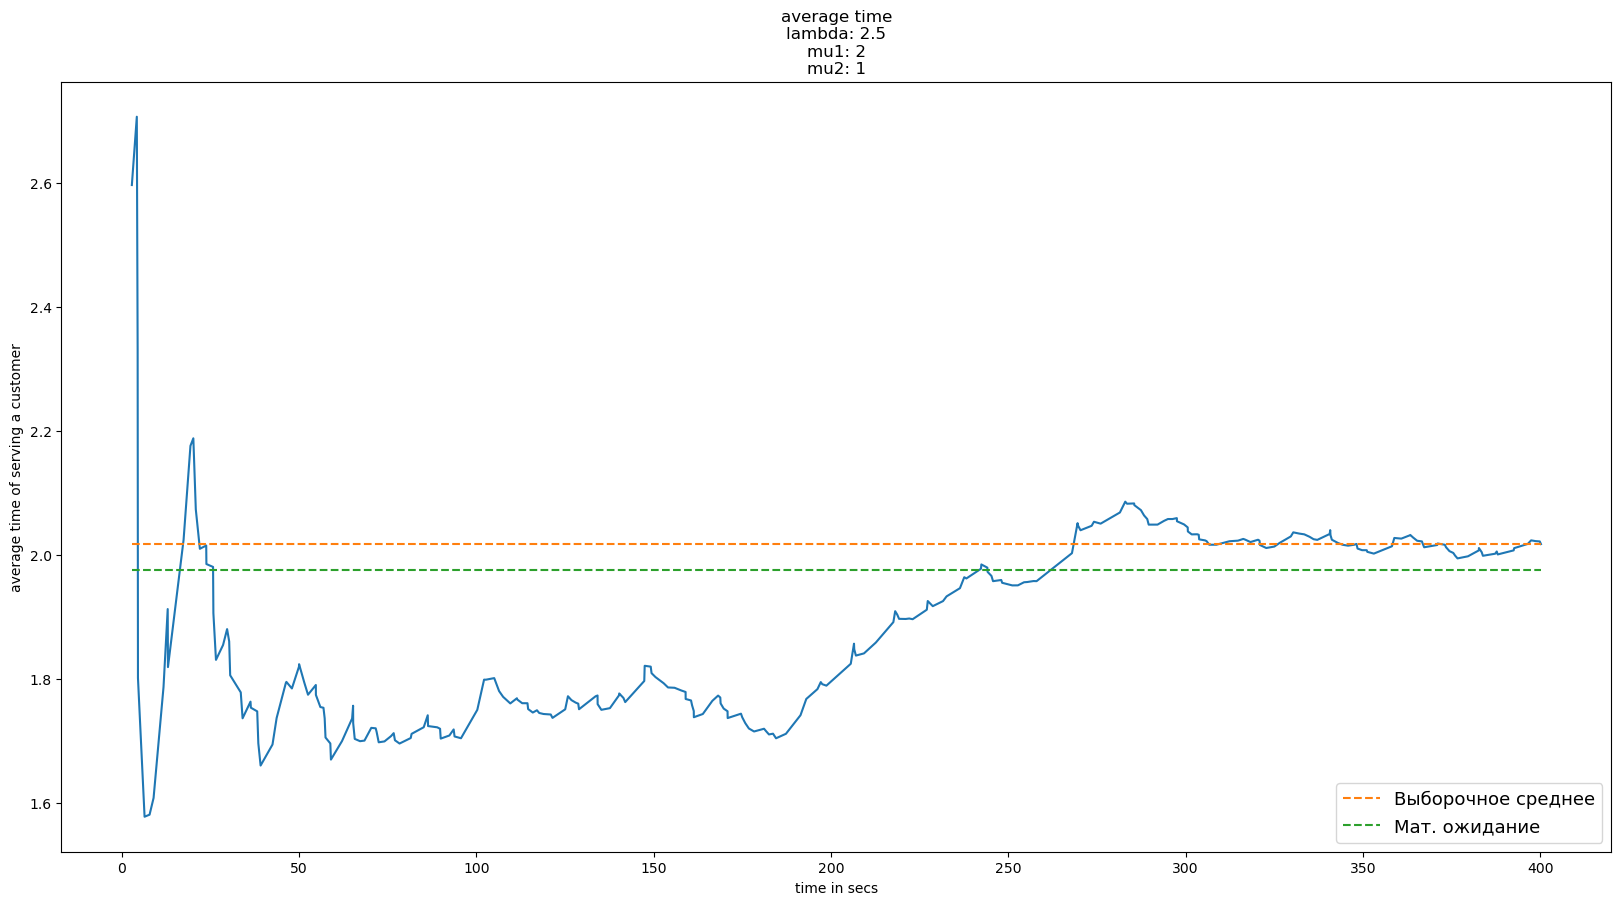

In [126]:
plot_time_avg(res3, stats3, lm, mu1, mu2)

### Эксперимент 4 (lm: 1, mu1: 2, mu2: 3)

In [127]:
lm = 1
mu1 = 2
mu2 = 3

In [72]:
clients_list = []
timings = []
stats4 = get_theor_stats(lm, mu1, mu2)
res4 = simulate(1000, lm, mu1, mu2)

100%|██████████| 1000/1000 [16:28<00:00,  1.01it/s]


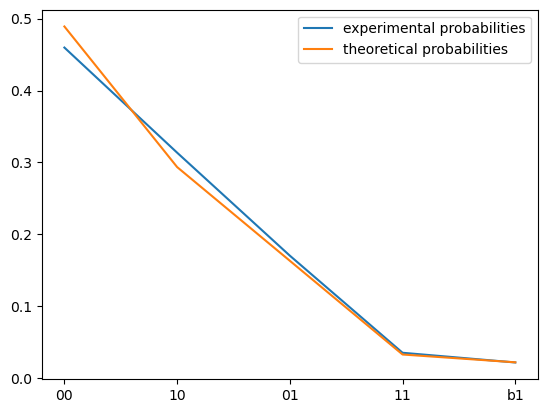

In [128]:
plt.plot(res4['probs'].keys(), res4['probs'].values(), label='experimental probabilities')
plt.plot(res4['probs'].keys(), stats4[0], label='theoretical probabilities')
plt.legend()

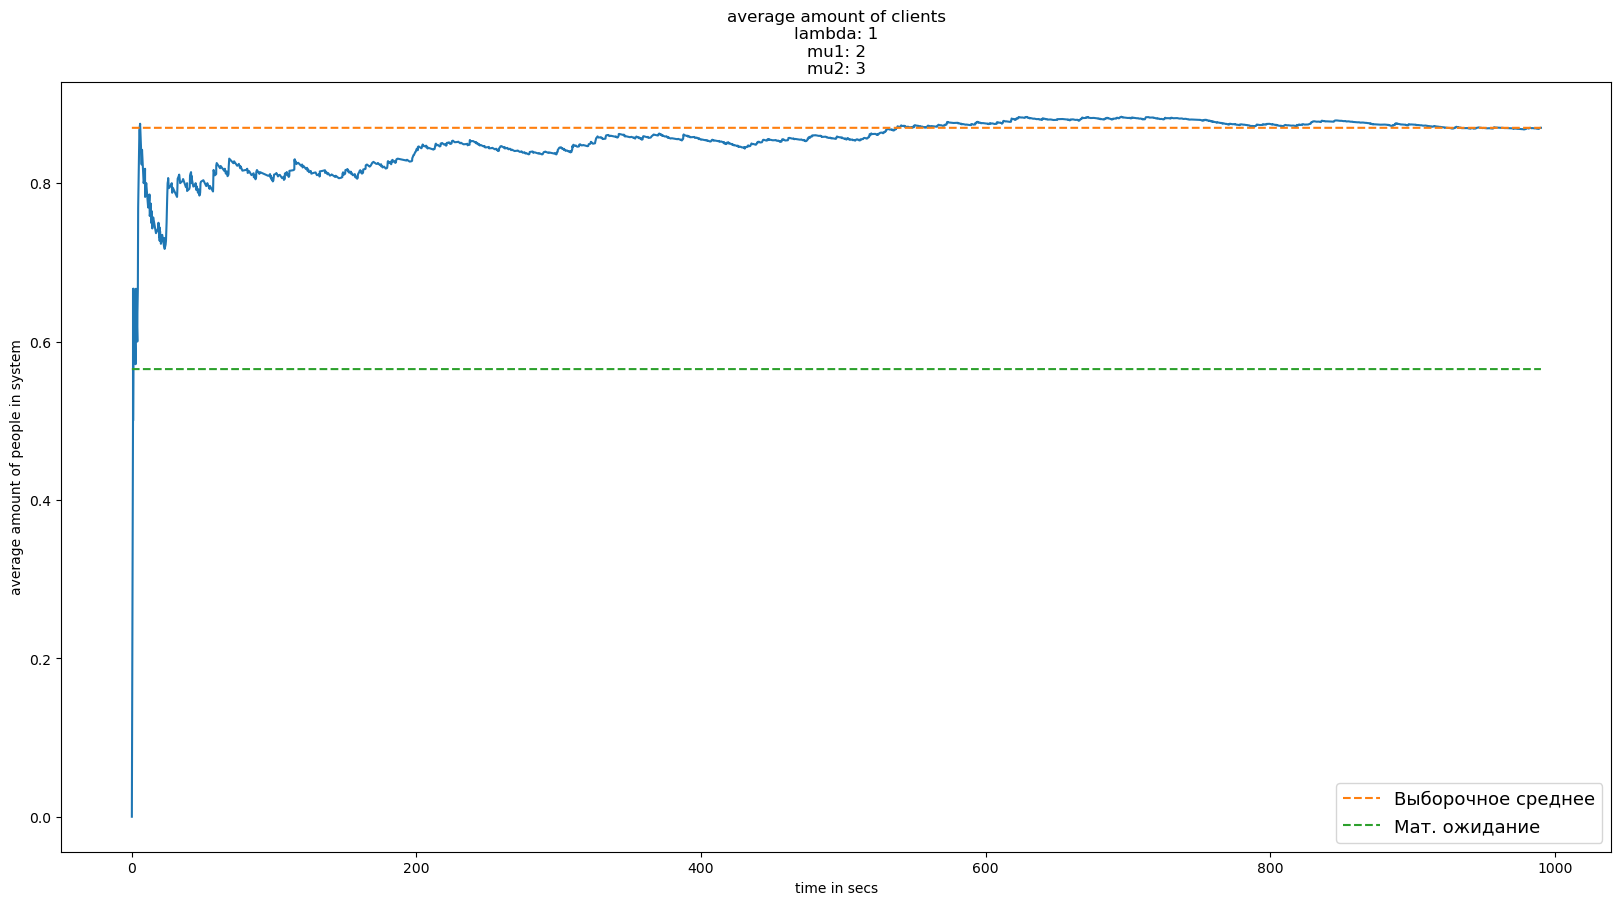

In [129]:
plot_clients_avg(res4, stats4, lm, mu1, mu2)

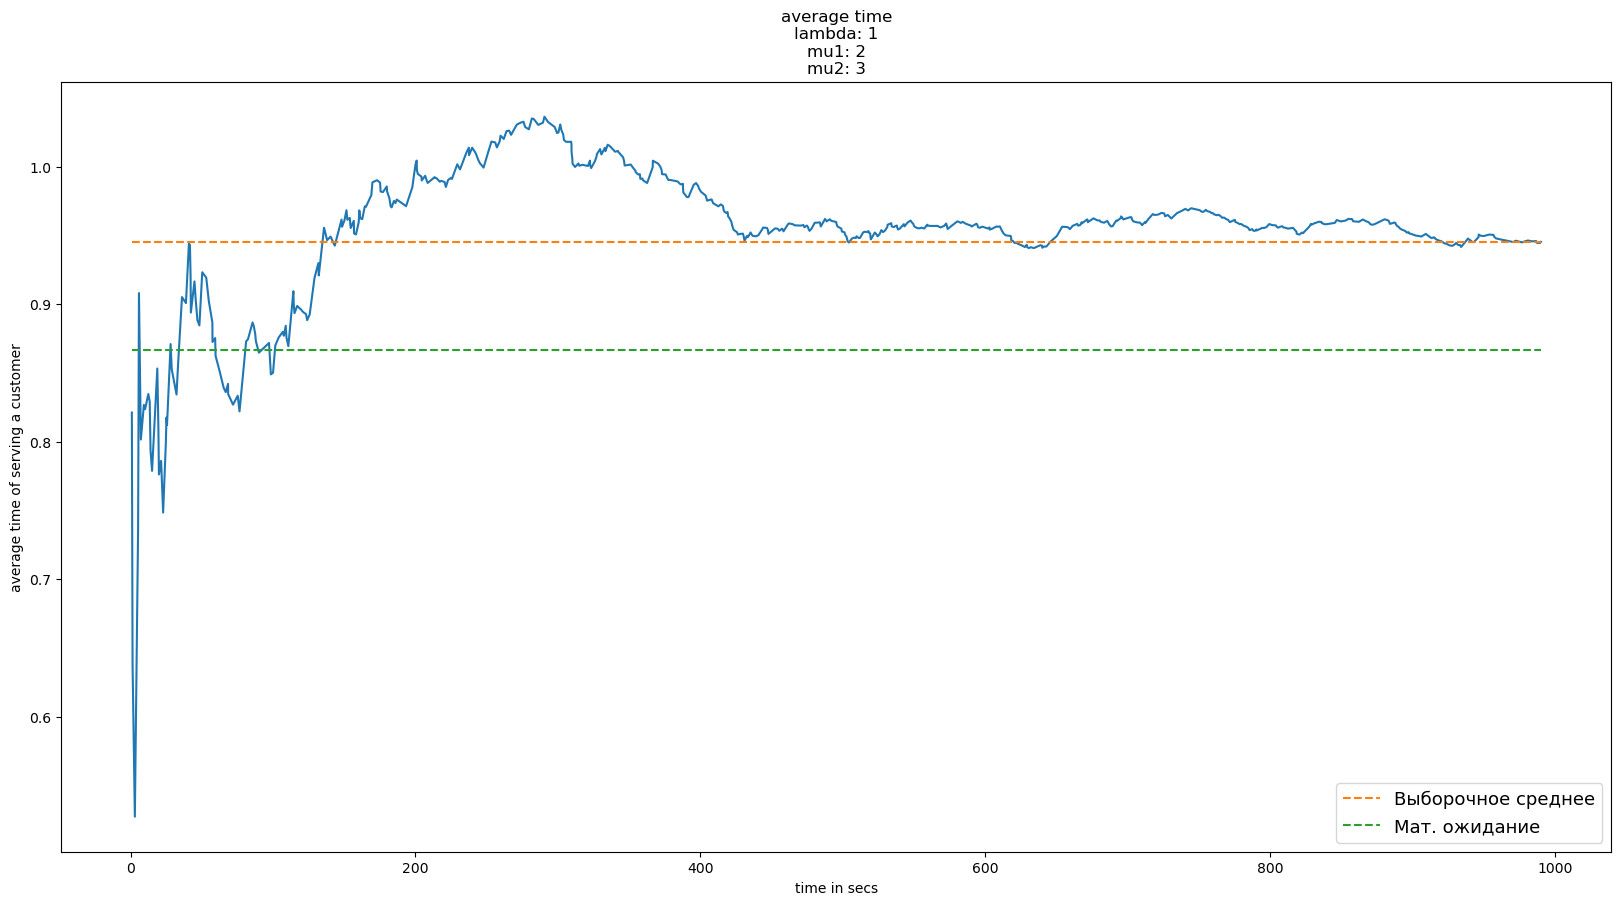

In [130]:
plot_time_avg(res4, stats4, lm, mu1, mu2)